In [1]:
# clear
%reset -f

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm, kstest, uniform, gamma, lognorm, beta, burr
#from sklearn.preprocessing import QuantileTransformer
from fitter import Fitter

In [3]:
def fit_distribution(data):
    #f = Fitter(data,distributions=get_distributions(),timeout=60,bins=30) 
    f = Fitter(data,distributions=['gamma','lognorm',"beta","burr","norm"],timeout=30,bins=30) 
    f.fit()
    return f.get_best()

In [4]:
def generate_correlation_matrix(correlations):
    num_variables = len(correlations)
    # Add jittering and check if the matrix is positive definite
    min_eig = np.min(np.real(np.linalg.eigvals(correlations)))
    while min_eig <= 0:
        correlations -= 10*min_eig * np.eye(*correlations.shape)
        min_eig = np.min(np.real(np.linalg.eigvals(correlations)))

    return correlations

In [5]:
def cholesky_decomposition(matrix):
    n = len(matrix)

    # Initialize an empty matrix
    L = [[0.0] * n for _ in range(n)]

    # Perform the Cholesky decomposition
    for i in range(n):
        for k in range(i+1):
            temp_sum = sum(L[i][j] * L[k][j] for j in range(k))
            
            if (i == k): # Diagonal elements
                # If the element is not positive, raise an exception
                if matrix[i][i] - temp_sum <= 0:
                    raise ValueError("The matrix is not positive-definite.")
                else:
                    L[i][k] = (matrix[i][i] - temp_sum) ** 0.5
            else:
                L[i][k] = (1.0 / L[k][k] * (matrix[i][k] - temp_sum))
    return L


In [6]:
def simulate_data(num_samples, distributions, cholesky_matrix):
    num_variables = len(distributions)
    samples = np.zeros((num_samples, num_variables))
    for i, distribution in enumerate(distributions):
        key_name = list(distributions[i].keys())[0]
        distribution = distributions[i]
        # Assuming distribution dictionary has 'type' and 'params' keys
        if key_name == ['norm']:
            dist = norm(loc=distribution['norm']['loc'], scale=distribution['norm']['scale'])
        elif key_name == 'uniform':
            dist = uniform(loc=distribution['params']['start'], scale=distribution['params']['end'])
        elif key_name == 'gamma':
            dist = gamma(a=distribution['params']['shape'], scale=distribution['params']['scale'])
        elif key_name == 'lognorm':
            dist = lognorm(s=distribution['params']['shape'], scale=distribution['params']['scale'])
        elif key_name == 'beta':
            dist = beta(a=distribution['beta']['a'], b=distribution['beta']['b'],loc=distribution['beta']['loc'], scale=distribution['beta']['scale'])
        elif key_name == 'burr':
            dist = burr(c=distribution['params']['c'], d=distribution['params']['d'])
        samples[:, i] = dist.rvs(num_samples)
    return np.dot(cholesky_matrix, samples.T).T


In [45]:
def validate_results(results, distributions):
    p_values = []
    ks_values = []  # Initialize ks_values
    for i, distribution in enumerate(distributions):
        key_name = list(distributions[i].keys())[0]  # Get the type of the distribution
        dist_params = distributions[i]    # Get the parameters of the distribution
        if key_name == 'norm':
            ks_value, p_value = kstest(results[:, i], 'norm', args=(dist_params['norm']['loc'], dist_params['norm']['scale']))
        elif key_name == 'uniform':
            ks_value, p_value = kstest(results[:, i], 'uniform', args=(dist_params['uniform']['loc'], dist_params['uniform']['scale']))
        elif key_name == 'gamma':
            ks_value, p_value = kstest(results[:, i], 'gamma', args=(dist_params['gamma']['shape'], dist_params['gamma']['scale']))
        elif key_name == 'lognorm':
            ks_value, p_value = kstest(results[:, i], 'lognorm', args=(dist_params['lognorm']['s'], dist_params['lognorm']['scale']))
        elif key_name == 'beta':
            ks_value, p_value = kstest(results[:, i], 'beta', args=(dist_params['beta']['a'], dist_params['beta']['b'], dist_params['beta']['loc'], dist_params['beta']['scale']))
        elif key_name == 'burr':
            ks_value, p_value = kstest(results[:, i], 'burr', args=(dist_params['burr']['c'], dist_params['burr']['d'], dist_params['burr']['loc'], dist_params['burr']['scale']))
        p_values.append(p_value)
        ks_values.append(ks_value)
    return p_values, ks_values  # Return ks_values along with p_values

In [8]:
# Example usage:
num_samples = 10000
#data = [np.random.normal(0, 1, num_samples) for _ in range(3)] # Replace with your data
data = np.genfromtxt('data.csv', delimiter=',')
correlations = [[1, 0.5, 0.2], [0.5, 1, 0.3], [0.2, 0.3, 1]] # Replace with your correlations

In [301]:
distributions = [fit_distribution(d) for d in data]
distributions

Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.27it/s]


[{'beta': {'a': 12352383.51025482,
   'b': 5719.6594360498775,
   'loc': -162085.62379419454,
   'scale': 162160.65873895132}},
 {'norm': {'loc': 0.008057123300412854, 'scale': 1.0041150087144464}},
 {'beta': {'a': 167.9614618937337,
   'b': 182.52055064038478,
   'loc': -18.011840230285763,
   'scale': 37.59701042384495}}]

In [302]:
correlation_matrix = generate_correlation_matrix(correlations)
correlation_matrix

[[1, 0.5, 0.2], [0.5, 1, 0.3], [0.2, 0.3, 1]]

In [303]:
cholesky_matrix = cholesky_decomposition(correlation_matrix)
cholesky_matrix

[[1.0, 0.0, 0.0],
 [0.5, 0.8660254037844386, 0.0],
 [0.2, 0.23094010767585033, 0.9521904571390466]]

In [304]:
simulated_data = simulate_data(num_samples, distributions, cholesky_matrix)
simulated_data

array([[ 0.01585006,  1.13719873, -0.94727178],
       [-1.56979158, -2.42576148, -4.09827042],
       [-1.14325787, -0.36374414, -0.24754392],
       ...,
       [ 0.54448053, -1.40283718, -1.81014344],
       [ 0.22840917,  0.06480319, -0.75809104],
       [-0.11429301,  1.39318491,  0.99431745]])

In [46]:
p_values, ks_values = validate_results(simulated_data, distributions)
p_values

[0.0006638117361680825, 0.007132807321056979, 1.7976407745331524e-06]

In [21]:
p_values=[1,1,1]
n=0
while any(p > 0.05 for p in p_values):
    n+=1
    print(n)
    try:
        num_samples = 10000
        data = [np.random.normal(0, 1, num_samples) for _ in range(3)] # Replace with your data
        correlations = [[1, 0.5, 0.2], [0.5, 1, 0.3], [0.2, 0.3, 1]] # Replace with your correlations
        distributions = [fit_distribution(d) for d in data]
        correlation_matrix = generate_correlation_matrix(correlations)
        cholesky_matrix = cholesky_decomposition(correlation_matrix)
        simulated_data = simulate_data(num_samples, distributions, cholesky_matrix)
        p_values = validate_results(simulated_data, distributions)
    except:
        continue
np.savetxt("data.csv", np.array(data).T, delimiter=",")

1


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.84it/s]


2


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.22it/s]


3


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


4


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.73it/s]


5


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.29it/s]


6


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.30it/s]


7


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.16it/s]


8


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.68it/s]


9


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.01it/s]


10


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.11it/s]


11


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.65it/s]


12


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.91it/s]


13


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.15it/s]


14


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.24it/s]


15


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.78it/s]


16


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.84it/s]


17


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.83it/s]


18


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.21it/s]


19


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.21it/s]


20


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.34it/s]


21


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.22it/s]


22


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.00it/s]


23


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.98it/s]


24


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.34it/s]


25


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.40it/s]


26


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.52it/s]


27


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.40it/s]


28


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.51it/s]


29


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.14it/s]


30


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.93it/s]


31


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.76it/s]


32


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.06it/s]


33


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.94it/s]


34


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.04it/s]


35


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.96it/s]


36


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.05it/s]


37


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.78it/s]


38


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.12it/s]


39


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.53it/s]


40


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.13it/s]


41


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.56it/s]


42


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.29it/s]


43


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.06it/s]


44


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.50it/s]


45


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.01it/s]


46


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.27it/s]


47


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


48


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


49


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.19it/s]


50


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.92it/s]


51


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.42it/s]


52


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.01it/s]


53


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.01it/s]


54


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.27it/s]


55


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.88it/s]


56


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.21it/s]


57


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.57it/s]


58


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.86it/s]


59


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.55it/s]


60


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.89it/s]


61


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 14.40it/s]


62


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


63


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.38it/s]


64


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.85it/s]


65


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.54it/s]


66


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.57it/s]


67


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.33it/s]


68


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.58it/s]


69


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.17it/s]


70


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.78it/s]


71


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.21it/s]


72


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.84it/s]


73


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.95it/s]


74


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.65it/s]


75


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.32it/s]


76


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.81it/s]


77


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.61it/s]


78


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.27it/s]


79


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.53it/s]


80


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.88it/s]


81


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.07it/s]


82


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.77it/s]


83


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.54it/s]


84


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.14it/s]


85


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.81it/s]


86


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


87


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.15it/s]


88


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.23it/s]


89


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.31it/s]


90


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.66it/s]


91


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


92


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.48it/s]


93


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.58it/s]


94


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.99it/s]


95


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.81it/s]


96


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.04it/s]


97


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.93it/s]


98


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.09it/s]


99


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.27it/s]


100


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.60it/s]


101


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.44it/s]


102


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.33it/s]


103


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.76it/s]


104


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.26it/s]


105


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.51it/s]


106


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.74it/s]


107


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.19it/s]


108


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.88it/s]


109


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.66it/s]


110


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.21it/s]


111


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.20it/s]


112


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.14it/s]


113


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.63it/s]


114


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.36it/s]


115


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.54it/s]


116


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


117


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.21it/s]


118


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.07it/s]


119


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.11it/s]


120


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.26it/s]


121


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.46it/s]


122


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.78it/s]


123


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


124


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.12it/s]


125


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.00it/s]


126


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.80it/s]


127


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.83it/s]


128


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.62it/s]


129


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.50it/s]


130


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.83it/s]


131


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.15it/s]


132


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.20it/s]


133


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.87it/s]


134


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.04it/s]


135


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.64it/s]


136


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.48it/s]


137


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.37it/s]


138


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.38it/s]


139


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.56it/s]


140


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.47it/s]


141


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.17it/s]


142


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.93it/s]


143


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.12it/s]


144


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.73it/s]


145


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.68it/s]


146


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.81it/s]


147


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.51it/s]


148


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.03it/s]


149


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.05it/s]


150


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.58it/s]


151


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.58it/s]


152


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.70it/s]


153


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.97it/s]


154


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.29it/s]


155


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.57it/s]


156


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.13it/s]


157


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.49it/s]


158


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.12it/s]


159


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


160


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.80it/s]


161


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.17it/s]


162


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.27it/s]


163


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.22it/s]


164


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.72it/s]


165


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.14it/s]


166


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.21it/s]


167


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


168


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.63it/s]


169


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.16it/s]


170


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.42it/s]


171


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.85it/s]


172


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.17it/s]


173


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.91it/s]


174


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.07it/s]


175


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.35it/s]


176


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


177


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.03it/s]


178


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.36it/s]


179


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.10it/s]


180


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.72it/s]


181


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.49it/s]


182


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.92it/s]


183


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.46it/s]


184


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.02it/s]


185


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.77it/s]


186


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.75it/s]


187


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.78it/s]


188


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.68it/s]


189


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.95it/s]


190


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.04it/s]


191


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.59it/s]


192


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.82it/s]


193


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.73it/s]


194


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.62it/s]


195


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.85it/s]


196


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.36it/s]


197


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.10it/s]


198


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.35it/s]


199


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.09it/s]


200


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.58it/s]


201


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.18it/s]


202


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.18it/s]


203


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.23it/s]


204


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.78it/s]


205


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.85it/s]


206


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.27it/s]


207


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.67it/s]


208


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.17it/s]


209


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.76it/s]


210


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.34it/s]


211


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.51it/s]


212


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.48it/s]


213


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.83it/s]


214


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.32it/s]


215


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.61it/s]


216


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.26it/s]


217


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.43it/s]


218


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.96it/s]


219


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.87it/s]


220


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.54it/s]


221


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.32it/s]


222


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.40it/s]


223


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.86it/s]


224


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.19it/s]


225


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.56it/s]


226


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.86it/s]


227


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.52it/s]


228


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


229


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.85it/s]


230


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.43it/s]


231


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.05it/s]


232


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.56it/s]


233


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.40it/s]


234


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.16it/s]


235


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.54it/s]


236


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.12it/s]


237


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.74it/s]


238


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.90it/s]


239


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.72it/s]


240


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.72it/s]


241


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.08it/s]


242


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.52it/s]


243


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.09it/s]


244


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.99it/s]


245


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.63it/s]


246


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.49it/s]


247


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.84it/s]


248


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.79it/s]


249


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.88it/s]


250


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.44it/s]


251


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.26it/s]


252


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.12it/s]


253


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.72it/s]


254


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.56it/s]


255


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


256


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.53it/s]


257


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.54it/s]


258


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.26it/s]


259


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


260


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.85it/s]


261


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


262


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


263


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.10it/s]


264


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.68it/s]


265


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.20it/s]


266


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.68it/s]


267


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.55it/s]


268


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


269


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.06it/s]


270


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.44it/s]


271


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.13it/s]


272


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.02it/s]


273


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.77it/s]


274


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.83it/s]


275


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.66it/s]


276


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.21it/s]


277


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.37it/s]


278


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.27it/s]


279


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.09it/s]


280


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.13it/s]


281


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.68it/s]


282


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


283


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.92it/s]


284


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.19it/s]


285


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.97it/s]


286


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


287


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.13it/s]


288


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


289


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.61it/s]


290


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.19it/s]


291


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.43it/s]


292


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.59it/s]


293


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.15it/s]


294


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.38it/s]


295


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.52it/s]


296


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.35it/s]


297


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.51it/s]


298


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.95it/s]


299


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


300


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.06it/s]


301


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.24it/s]


302


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.84it/s]


303


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.29it/s]


304


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.43it/s]


305


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.24it/s]


306


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.20it/s]


307


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.04it/s]


308


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.98it/s]


309


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.64it/s]


310


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.61it/s]


311


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.86it/s]


312


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.41it/s]


313


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.01it/s]


314


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.99it/s]


315


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.68it/s]


316


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.51it/s]


317


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.17it/s]


318


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.52it/s]


319


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.53it/s]


320


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.76it/s]


321


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.45it/s]


322


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.41it/s]


323


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.43it/s]


324


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


325


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.87it/s]


326


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.57it/s]


327


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.21it/s]


328


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.02it/s]


329


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.35it/s]


330


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.15it/s]


331


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.72it/s]


332


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


333


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.48it/s]


334


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.87it/s]


335


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.06it/s]


336


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.05it/s]


337


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.90it/s]


338


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.09it/s]


339


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.43it/s]


340


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.48it/s]


341


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.72it/s]


342


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.18it/s]


343


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.87it/s]


344


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.77it/s]


345


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.99it/s]


346


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.07it/s]


347


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.01it/s]


348


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.36it/s]


349


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.39it/s]


350


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.07it/s]


351


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.00it/s]


352


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.50it/s]


353


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.03it/s]


354


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.69it/s]


355


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.22it/s]


356


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.34it/s]


357


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.92it/s]


358


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.04it/s]


359


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.02it/s]


360


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.56it/s]


361


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.83it/s]


362


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.69it/s]


363


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 13.79it/s]


364


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.26it/s]


365


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.34it/s]


366


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.97it/s]


367


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.45it/s]


368


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.15it/s]


369


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.28it/s]


370


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.56it/s]


371


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.33it/s]


372


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.62it/s]


373


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.72it/s]


374


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.54it/s]


375


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.94it/s]


376


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


377


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.97it/s]


378


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.44it/s]


379


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.02it/s]


380


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.58it/s]


381


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.98it/s]


382


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.93it/s]


383


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.82it/s]


384


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.79it/s]


385


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.38it/s]


386


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.07it/s]


387


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.88it/s]


388


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.54it/s]


389


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.78it/s]


390


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.52it/s]


391


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.78it/s]


392


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.51it/s]


393


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


394


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.06it/s]


395


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.97it/s]


396


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.97it/s]


397


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.77it/s]


398


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.83it/s]


399


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.76it/s]


400


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.11it/s]


401


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.51it/s]


402


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.54it/s]


403


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.69it/s]


404


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.45it/s]


405


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.19it/s]


406


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.56it/s]


407


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.12it/s]


408


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.50it/s]


409


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.84it/s]


410


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.83it/s]


411


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.40it/s]


412


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.95it/s]


413


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.40it/s]


414


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.35it/s]


415


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.65it/s]


416


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


417


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.81it/s]


418


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.92it/s]


419


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.55it/s]


420


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.84it/s]


421


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


422


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.52it/s]


423


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.20it/s]


424


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.98it/s]


425


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.57it/s]


426


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.96it/s]


427


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.60it/s]


428


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.58it/s]


429


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


430


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.18it/s]


431


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.23it/s]


432


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.29it/s]


433


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.94it/s]


434


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.33it/s]


435


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.58it/s]


436


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.01it/s]


437


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.09it/s]


438


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.77it/s]


439


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.77it/s]


440


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.97it/s]


441


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.91it/s]


442


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.47it/s]


443


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.45it/s]


444


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.31it/s]


445


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.46it/s]


446


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.06it/s]


447


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.24it/s]


448


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.18it/s]


449


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.48it/s]


450


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


451


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.81it/s]


452


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.55it/s]


453


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.00it/s]


454


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.26it/s]


455


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.40it/s]


456


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.65it/s]


457


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.78it/s]


458


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


459


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.35it/s]


460


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.21it/s]


461


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.96it/s]


462


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.91it/s]


463


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.64it/s]


464


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.34it/s]


465


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.38it/s]


466


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.75it/s]


467


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.19it/s]


468


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.83it/s]


469


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.36it/s]


470


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.89it/s]


471


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.78it/s]


472


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.77it/s]


473


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.60it/s]


474


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.02it/s]


475


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.91it/s]


476


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.84it/s]


477


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.14it/s]


478


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.26it/s]


479


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.33it/s]


480


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.85it/s]


481


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.78it/s]


482


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.30it/s]


483


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.48it/s]


484


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.67it/s]


485


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.29it/s]


486


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.45it/s]


487


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.22it/s]


488


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.69it/s]


489


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.32it/s]


490


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.26it/s]


491


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.89it/s]


492


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.30it/s]


493


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.22it/s]


494


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.20it/s]


495


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.52it/s]


496


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.11it/s]


497


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.38it/s]


498


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.90it/s]


499


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


500


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.42it/s]


501


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.01it/s]


502


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.69it/s]


503


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.93it/s]


504


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.67it/s]


505


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.32it/s]


506


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.14it/s]


507


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.46it/s]


508


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.25it/s]


509


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.00it/s]


510


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.25it/s]


511


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.85it/s]


512


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.64it/s]


513


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.89it/s]


514


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.96it/s]


515


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.13it/s]


516


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.33it/s]


517


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.47it/s]


518


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.03it/s]


519


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


520


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.73it/s]


521


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.51it/s]


522


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.86it/s]


523


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.05it/s]


524


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.17it/s]


525


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.73it/s]


526


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


527


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.49it/s]


528


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.01it/s]


529


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.72it/s]


530


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.97it/s]


531


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.49it/s]


532


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.79it/s]


533


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.61it/s]


534


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.44it/s]


535


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.06it/s]


536


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.50it/s]


537


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.22it/s]


538


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.57it/s]


539


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.95it/s]


540


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.77it/s]


541


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.56it/s]


542


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.93it/s]


543


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.52it/s]


544


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.21it/s]


545


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


546


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.20it/s]


547


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.54it/s]


548


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.03it/s]


549


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.78it/s]


550


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.08it/s]


551


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.75it/s]


552


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.85it/s]


553


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.16it/s]


554


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.48it/s]


555


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.91it/s]


556


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.42it/s]


557


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.22it/s]


558


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.92it/s]


559


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.81it/s]


560


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.45it/s]


561


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.30it/s]


562


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.78it/s]


563


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.23it/s]


564


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.85it/s]


565


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.85it/s]


566


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 13.18it/s]


567


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


568


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.52it/s]


569


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.99it/s]


570


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.94it/s]


571


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.01it/s]


572


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.09it/s]


573


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.51it/s]


574


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.46it/s]


575


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.86it/s]


576


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.93it/s]


577


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.75it/s]


578


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.03it/s]


579


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.52it/s]


580


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.13it/s]


581


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.53it/s]


582


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.22it/s]


583


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.29it/s]


584


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.49it/s]


585


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


586


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.71it/s]


587


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.24it/s]


588


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.56it/s]


589


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.41it/s]


590


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.92it/s]


591


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.67it/s]


592


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.30it/s]


593


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.91it/s]


594


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.62it/s]


595


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.97it/s]


596


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.97it/s]


597


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.63it/s]


598


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


599


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.35it/s]


600


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.06it/s]


601


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.28it/s]


602


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.58it/s]


603


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.39it/s]


604


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.76it/s]


605


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.92it/s]


606


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.22it/s]


607


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.34it/s]


608


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.75it/s]


609


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.98it/s]


610


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.03it/s]


611


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.12it/s]


612


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.17it/s]


613


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


614


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.27it/s]


615


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.13it/s]


616


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


617


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 13.89it/s]


618


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.65it/s]


619


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.21it/s]


620


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.86it/s]


621


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.54it/s]


622


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.75it/s]


623


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.13it/s]


624


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.50it/s]


625


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.38it/s]


626


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.69it/s]


627


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.05it/s]


628


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.04it/s]


629


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.16it/s]


630


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.74it/s]


631


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.63it/s]


632


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.88it/s]


633


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.98it/s]


634


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 13.86it/s]


635


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.54it/s]


636


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.23it/s]


637


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


638


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.00it/s]


639


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.73it/s]


640


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.15it/s]


641


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.18it/s]


642


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.85it/s]


643


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.26it/s]


644


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.50it/s]


645


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.41it/s]


646


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.95it/s]


647


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.38it/s]


648


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.93it/s]


649


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.02it/s]


650


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.67it/s]


651


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.04it/s]


652


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.99it/s]


653


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.00it/s]


654


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.93it/s]


655


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.09it/s]


656


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.44it/s]


657


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.63it/s]


658


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


659


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.90it/s]


660


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.75it/s]


661


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.64it/s]


662


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.05it/s]


663


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.99it/s]


664


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.23it/s]


665


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.92it/s]


666


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.53it/s]


667


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.85it/s]


668


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.45it/s]


669


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.36it/s]


670


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.37it/s]


671


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.02it/s]


672


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.35it/s]


673


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


674


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 14.63it/s]


675


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.72it/s]


676


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.67it/s]


677


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.30it/s]


678


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.49it/s]


679


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.24it/s]


680


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.97it/s]


681


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


682


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.51it/s]


683


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.85it/s]


684


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.61it/s]


685


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.21it/s]


686


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.01it/s]


687


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.66it/s]


688


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.23it/s]


689


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.53it/s]


690


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.01it/s]


691


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.55it/s]


692


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.78it/s]


693


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.23it/s]


694


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.25it/s]


695


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.87it/s]


696


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.26it/s]


697


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.61it/s]


698


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.33it/s]


699


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


700


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.69it/s]


701


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.30it/s]


702


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.49it/s]


703


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.94it/s]


704


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.60it/s]


705


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.02it/s]


706


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.05it/s]


707


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.27it/s]


708


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.56it/s]


709


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.34it/s]


710


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.61it/s]


711


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.46it/s]


712


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.76it/s]


713


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.39it/s]


714


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.33it/s]


715


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.03it/s]


716


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.86it/s]


717


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.30it/s]


718


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.82it/s]


719


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.33it/s]


720


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.28it/s]


721


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.62it/s]


722


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


723


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.43it/s]


724


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.31it/s]


725


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.07it/s]


726


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.99it/s]


727


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.13it/s]


728


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.32it/s]


729


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.38it/s]


730


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.72it/s]


731


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.60it/s]


732


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.40it/s]


733


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.24it/s]


734


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.84it/s]


735


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.05it/s]


736


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.38it/s]


737


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.78it/s]


738


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.18it/s]


739


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.78it/s]


740


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  3.21it/s]


741


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.21it/s]


742


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.45it/s]


743


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


744


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.55it/s]


745


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.12it/s]


746


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.42it/s]


747


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.52it/s]


748


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.14it/s]


749


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.27it/s]


750


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.03it/s]


751


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.64it/s]


752


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 13.94it/s]


753


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.82it/s]


754


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.25it/s]


755


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.11it/s]


756


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.23it/s]


757


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.06it/s]


758


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.01it/s]


759


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.41it/s]


760


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


761


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.03it/s]


762


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.03it/s]


763


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.79it/s]


764


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.12it/s]


765


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.50it/s]


766


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


767


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.36it/s]


768


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.30it/s]


769


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.74it/s]


770


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.38it/s]


771


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.84it/s]


772


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.20it/s]


773


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.22it/s]


774


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.21it/s]


775


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.84it/s]


776


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.83it/s]


777


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.61it/s]


778


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.37it/s]


779


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.93it/s]


780


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.15it/s]


781


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.79it/s]


782


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.77it/s]


783


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.94it/s]


784


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


785


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.73it/s]


786


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.90it/s]


787


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


788


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.01it/s]


789


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.61it/s]


790


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.00it/s]


791


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.10it/s]


792


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.37it/s]


793


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.32it/s]


794


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.36it/s]


795


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.96it/s]


796


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


797


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.57it/s]


798


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.17it/s]


799


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.14it/s]


800


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.86it/s]


801


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.52it/s]


802


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.10it/s]


803


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.33it/s]


804


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.98it/s]


805


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.93it/s]


806


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.55it/s]


807


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.81it/s]


808


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.98it/s]


809


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.92it/s]


810


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.23it/s]


811


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.72it/s]


812


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.14it/s]


813


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.38it/s]


814


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.13it/s]


815


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.34it/s]


816


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.39it/s]


817


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.06it/s]


818


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.34it/s]


819


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.40it/s]


820


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.72it/s]


821


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.05it/s]


822


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.37it/s]


823


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.13it/s]


824


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.20it/s]


825


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.53it/s]


826


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.52it/s]


827


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.24it/s]


828


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.46it/s]


829


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.75it/s]


830


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.10it/s]


831


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.77it/s]


832


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 13.33it/s]


833


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.73it/s]


834


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.83it/s]


835


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


836


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.44it/s]


837


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.68it/s]


838


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.17it/s]


839


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.64it/s]


840


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.99it/s]


841


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.21it/s]


842


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.97it/s]


843


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.21it/s]


844


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.37it/s]


845


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.33it/s]


846


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.86it/s]


847


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.16it/s]


848


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.96it/s]


849


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.57it/s]


850


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


851


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.55it/s]


852


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.32it/s]


853


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.05it/s]


854


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.25it/s]


855


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.67it/s]


856


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.25it/s]


857


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.30it/s]


858


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.28it/s]


859


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.14it/s]


860


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.85it/s]


861


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.79it/s]


862


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.06it/s]


863


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.79it/s]


864


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


865


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.27it/s]


866


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.41it/s]


867


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.87it/s]


868


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.53it/s]


869


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.35it/s]


870


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.68it/s]


871


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.43it/s]


872


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.50it/s]


873


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.01it/s]


874


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.68it/s]


875


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.46it/s]


876


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.28it/s]


877


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.46it/s]


878


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.09it/s]


879


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.97it/s]


880


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.24it/s]


881


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.93it/s]


882


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.68it/s]


883


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.33it/s]


884


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.38it/s]


885


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 13.38it/s]


886


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.73it/s]


887


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.54it/s]


888


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


889


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.14it/s]


890


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.84it/s]


891


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.48it/s]


892


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.28it/s]


893


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.19it/s]


894


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.46it/s]


895


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.79it/s]


896


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.15it/s]


897


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.13it/s]


898


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.49it/s]


899


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.57it/s]


900


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.42it/s]


901


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.51it/s]


902


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.10it/s]


903


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.68it/s]


904


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.75it/s]


905


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.00it/s]


906


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  3.09it/s]


907


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.36it/s]


908


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.07it/s]


909


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.57it/s]


910


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.25it/s]


911


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.25it/s]


912


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.98it/s]


913


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.00it/s]


914


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  3.63it/s]


915


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.19it/s]


916


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.97it/s]


917


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.98it/s]


918


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.40it/s]


919


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.30it/s]


920


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.41it/s]


921


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.81it/s]


922


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.69it/s]


923


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.62it/s]


924


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.35it/s]


925


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.21it/s]


926


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.85it/s]


927


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.29it/s]


928


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.96it/s]


929


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.25it/s]


930


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.43it/s]


931


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


932


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.16it/s]


933


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.79it/s]


934


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.09it/s]


935


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.73it/s]


936


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.74it/s]


937


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.44it/s]


938


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.68it/s]


939


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.93it/s]


940


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.60it/s]


941


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 13.11it/s]


942


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.48it/s]


943


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.19it/s]


944


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.30it/s]


945


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.27it/s]


946


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 13.13it/s]


947


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.02it/s]


948


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.93it/s]


949


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.94it/s]


950


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.85it/s]


951


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.62it/s]


952


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.17it/s]


953


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.81it/s]


954


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.99it/s]


955


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


956


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.52it/s]


957


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.51it/s]


958


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.31it/s]


959


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.90it/s]


960


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


961


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.22it/s]


962


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.04it/s]


963


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.19it/s]


964


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.56it/s]


965


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.87it/s]


966


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.51it/s]


967


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.24it/s]


968


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.14it/s]


969


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.94it/s]


970


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.89it/s]


971


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.97it/s]


972


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.17it/s]


973


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.53it/s]


974


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.06it/s]


975


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.81it/s]


976


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.77it/s]


977


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.58it/s]


978


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.05it/s]


979


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.08it/s]


980


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.21it/s]


981


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.84it/s]


982


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.70it/s]


983


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.46it/s]


984


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.15it/s]


985


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


986


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.06it/s]


987


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.37it/s]


988


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.27it/s]


989


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.88it/s]


990


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.55it/s]


991


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.46it/s]


992


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.99it/s]


993


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.33it/s]


994


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.91it/s]


995


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.53it/s]


996


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.86it/s]


997


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


998


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.77it/s]


999


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.30it/s]


1000


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.88it/s]


1001


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.75it/s]


1002


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.42it/s]


1003


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.45it/s]


1004


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.25it/s]


1005


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.30it/s]


1006


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.87it/s]


1007


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.36it/s]


1008


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.26it/s]


1009


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.43it/s]


1010


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.46it/s]


1011


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.41it/s]


1012


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.46it/s]


1013


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.24it/s]


1014


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.06it/s]


1015


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.79it/s]


1016


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.99it/s]


1017


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.90it/s]


1018


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.85it/s]


1019


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.12it/s]


1020


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.98it/s]


1021


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.28it/s]


1022


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.06it/s]


1023


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.15it/s]


1024


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.57it/s]


1025


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.35it/s]


1026


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.43it/s]


1027


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.44it/s]


1028


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.38it/s]


1029


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.03it/s]


1030


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.68it/s]


1031


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.30it/s]


1032


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.31it/s]


1033


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.64it/s]


1034


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.45it/s]


1035


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.51it/s]


1036


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.86it/s]


1037


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.36it/s]


1038


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.28it/s]


1039


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.94it/s]


1040


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.25it/s]


1041


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.94it/s]


1042


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.26it/s]


1043


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.24it/s]


1044


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.15it/s]


1045


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.42it/s]


1046


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.66it/s]


1047


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.38it/s]


1048


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.83it/s]


1049


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.58it/s]


1050


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.44it/s]


1051


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.76it/s]


1052


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.69it/s]


1053


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.19it/s]


1054


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.83it/s]


1055


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.72it/s]


1056


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.63it/s]


1057


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.68it/s]


1058


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.09it/s]


1059


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.50it/s]


1060


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.43it/s]


1061


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.56it/s]


1062


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.39it/s]


1063


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.69it/s]


1064


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.04it/s]


1065


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.41it/s]


1066


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.76it/s]


1067


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.65it/s]


1068


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.34it/s]


1069


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.31it/s]


1070


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.86it/s]


1071


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.45it/s]


1072


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.53it/s]


1073


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.65it/s]


1074


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.03it/s]


1075


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.26it/s]


1076


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.99it/s]


1077


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.21it/s]


1078


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


1079


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.58it/s]


1080


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.30it/s]


1081


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.62it/s]


1082


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


1083


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.24it/s]


1084


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.98it/s]


1085


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.88it/s]


1086


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


1087


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.62it/s]


1088


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.85it/s]


1089


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.07it/s]


1090


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.88it/s]


1091


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.84it/s]


1092


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.12it/s]


1093


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.75it/s]


1094


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.48it/s]


1095


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.88it/s]


1096


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.27it/s]


1097


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.74it/s]


1098


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.11it/s]


1099


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.65it/s]


1100


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


1101


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.38it/s]


1102


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


1103


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.15it/s]


1104


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.30it/s]


1105


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.18it/s]


1106


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.77it/s]


1107


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.00it/s]


1108


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.12it/s]


1109


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.30it/s]


1110


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.53it/s]


1111


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.83it/s]


1112


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.34it/s]


1113


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.92it/s]


1114


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.29it/s]


1115


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.35it/s]


1116


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.76it/s]


1117


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.89it/s]


1118


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.77it/s]


1119


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.18it/s]


1120


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.08it/s]


1121


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.54it/s]


1122


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.39it/s]


1123


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.12it/s]


1124


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.94it/s]


1125


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:02<00:00,  2.04it/s]


1126


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.43it/s]


1127


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.44it/s]


1128


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.68it/s]


1129


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 14.30it/s]


1130


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.14it/s]


1131


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.49it/s]


1132


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.51it/s]


1133


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.46it/s]


1134


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.43it/s]


1135


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.99it/s]


1136


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.20it/s]


1137


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.15it/s]


1138


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.43it/s]


1139


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.40it/s]


1140


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.05it/s]


1141


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.00it/s]


1142


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.42it/s]


1143


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.05it/s]


1144


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


1145


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.59it/s]


1146


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.03it/s]


1147


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.61it/s]


1148


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


1149


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.03it/s]


1150


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.87it/s]


1151


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.79it/s]


1152


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.46it/s]


1153


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.64it/s]


1154


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.08it/s]


1155


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.30it/s]


1156


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.58it/s]


1157


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.67it/s]


1158


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.63it/s]


1159


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.97it/s]


1160


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.26it/s]


1161


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.66it/s]


1162


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.41it/s]


1163


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.35it/s]


1164


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.50it/s]


1165


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.46it/s]


1166


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.81it/s]


1167


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.20it/s]


1168


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.48it/s]


1169


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.42it/s]


1170


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.12it/s]


1171


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.06it/s]


1172


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.74it/s]


1173


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.43it/s]


1174


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.61it/s]


1175


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.36it/s]


1176


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.76it/s]


1177


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.36it/s]


1178


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.50it/s]


1179


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.49it/s]


1180


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.87it/s]


1181


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.64it/s]


1182


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.97it/s]


1183


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.92it/s]


1184


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.28it/s]


1185


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.63it/s]


1186


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.84it/s]


1187


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.96it/s]


1188


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.69it/s]


1189


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.99it/s]


1190


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.30it/s]


1191


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.00it/s]


1192


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.48it/s]


1193


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.98it/s]


1194


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.34it/s]


1195


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.32it/s]


1196


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.18it/s]


1197


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.24it/s]


1198


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.07it/s]


1199


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.64it/s]


1200


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.00it/s]


1201


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.09it/s]


1202


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.48it/s]


1203


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.76it/s]


1204


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.00it/s]


1205


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.75it/s]


1206


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.79it/s]


1207


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.75it/s]


1208


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.73it/s]


1209


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.32it/s]


1210


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.98it/s]


1211


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.41it/s]


1212


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.69it/s]


1213


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.02it/s]


1214


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.23it/s]


1215


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.25it/s]


1216


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.55it/s]


1217


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.33it/s]


1218


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.25it/s]


1219


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.21it/s]


1220


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.37it/s]


1221


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


1222


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.03it/s]


1223


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.16it/s]


1224


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.77it/s]


1225


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.71it/s]


1226


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.96it/s]


1227


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.74it/s]


1228


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.05it/s]


1229


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.26it/s]


1230


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.76it/s]


1231


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.84it/s]


1232


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.12it/s]


1233


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.77it/s]


1234


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


1235


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  3.39it/s]


1236


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.78it/s]


1237


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.09it/s]


1238


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.68it/s]


1239


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.05it/s]


1240


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.13it/s]


1241


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.88it/s]


1242


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.49it/s]


1243


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


1244


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.13it/s]


1245


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.01it/s]


1246


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.90it/s]


1247


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.01it/s]


1248


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


1249


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.60it/s]


1250


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.47it/s]


1251


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.32it/s]


1252


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.78it/s]


1253


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.29it/s]


1254


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.43it/s]


1255


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.16it/s]


1256


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.03it/s]


1257


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.08it/s]


1258


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


1259


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.99it/s]


1260


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.81it/s]


1261


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.43it/s]


1262


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.89it/s]


1263


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.45it/s]


1264


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


1265


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.30it/s]


1266


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.56it/s]


1267


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.19it/s]


1268


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.56it/s]


1269


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.83it/s]


1270


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.92it/s]


1271


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.48it/s]


1272


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.46it/s]


1273


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.42it/s]


1274


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.96it/s]


1275


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.51it/s]


1276


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.53it/s]


1277


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.07it/s]


1278


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.63it/s]


1279


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.01it/s]


1280


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.84it/s]


1281


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.81it/s]


1282


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.57it/s]


1283


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


1284


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.15it/s]


1285


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.83it/s]


1286


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.83it/s]


1287


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.42it/s]


1288


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.90it/s]


1289


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.79it/s]


1290


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.30it/s]


1291


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.64it/s]


1292


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.43it/s]


1293


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.25it/s]


1294


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.39it/s]


1295


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.61it/s]


1296


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.04it/s]


1297


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.51it/s]


1298


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.44it/s]


1299


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.32it/s]


1300


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.38it/s]


1301


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.95it/s]


1302


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.85it/s]


1303


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


1304


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.95it/s]


1305


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.12it/s]


1306


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.83it/s]


1307


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.73it/s]


1308


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


1309


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.23it/s]


1310


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.07it/s]


1311


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.05it/s]


1312


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.30it/s]


1313


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.94it/s]


1314


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.97it/s]


1315


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.01it/s]


1316


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.07it/s]


1317


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.27it/s]


1318


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.84it/s]


1319


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.57it/s]


1320


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.56it/s]


1321


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


1322


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.03it/s]


1323


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.23it/s]


1324


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


1325


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.11it/s]


1326


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.44it/s]


1327


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


1328


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.09it/s]


1329


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.34it/s]


1330


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.82it/s]


1331


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.56it/s]


1332


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.54it/s]


1333


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.48it/s]


1334


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.01it/s]


1335


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.03it/s]


1336


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.23it/s]


1337


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.12it/s]


1338


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.42it/s]


1339


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.65it/s]


1340


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.88it/s]


1341


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.95it/s]


1342


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.43it/s]


1343


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.68it/s]


1344


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.04it/s]


1345


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.10it/s]


1346


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  3.31it/s]


1347


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


1348


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.24it/s]


1349


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.81it/s]


1350


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.90it/s]


1351


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.38it/s]


1352


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.87it/s]


1353


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.23it/s]


1354


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.25it/s]


1355


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.57it/s]


1356


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.46it/s]


1357


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.66it/s]


1358


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.91it/s]


1359


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.03it/s]


1360


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.07it/s]


1361


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.69it/s]


1362


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.49it/s]


1363


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.75it/s]


1364


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.02it/s]


1365


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.78it/s]


1366


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 14.62it/s]


1367


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


1368


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.35it/s]


1369


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.22it/s]


1370


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.77it/s]


1371


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.51it/s]


1372


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.09it/s]


1373


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.72it/s]


1374


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.08it/s]


1375


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.81it/s]


1376


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.32it/s]


1377


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


1378


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.95it/s]


1379


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 13.92it/s]


1380


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.27it/s]


1381


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.45it/s]


1382


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.43it/s]


1383


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.33it/s]


1384


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.85it/s]


1385


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.10it/s]


1386


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.75it/s]


1387


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.10it/s]


1388


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.81it/s]


1389


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.88it/s]


1390


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.31it/s]


1391


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.02it/s]


1392


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.15it/s]


1393


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.05it/s]


1394


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.39it/s]


1395


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.85it/s]


1396


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.82it/s]


1397


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


1398


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.91it/s]


1399


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.88it/s]


1400


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.14it/s]


1401


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.42it/s]


1402


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.58it/s]


1403


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


1404


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.72it/s]


1405


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.17it/s]


1406


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.50it/s]


1407


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.73it/s]


1408


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.18it/s]


1409


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.76it/s]


1410


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.85it/s]


1411


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.04it/s]


1412


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.07it/s]


1413


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.28it/s]


1414


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.77it/s]


1415


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.98it/s]


1416


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.40it/s]


1417


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.95it/s]


1418


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


1419


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.11it/s]


1420


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.74it/s]


1421


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.15it/s]


1422


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.42it/s]


1423


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.32it/s]


1424


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.12it/s]


1425


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.40it/s]


1426


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.48it/s]


1427


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.95it/s]


1428


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.31it/s]


1429


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.81it/s]


1430


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.10it/s]


1431


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.26it/s]


1432


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.74it/s]


1433


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.90it/s]


1434


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.11it/s]


1435


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.75it/s]


1436


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.66it/s]


1437


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.71it/s]


1438


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.77it/s]


1439


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.17it/s]


1440


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.91it/s]


1441


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.02it/s]


1442


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.00it/s]


1443


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.76it/s]


1444


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.23it/s]


1445


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.33it/s]


1446


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.44it/s]


1447


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


1448


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.20it/s]


1449


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.25it/s]


1450


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.87it/s]


1451


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.65it/s]


1452


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.68it/s]


1453


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


1454


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.41it/s]


1455


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.43it/s]


1456


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.32it/s]


1457


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.18it/s]


1458


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.74it/s]


1459


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.24it/s]


1460


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


1461


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.37it/s]


1462


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.99it/s]


1463


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.33it/s]


1464


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.49it/s]


1465


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.20it/s]


1466


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.00it/s]


1467


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.29it/s]


1468


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.01it/s]


1469


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.80it/s]


1470


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.45it/s]


1471


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.49it/s]


1472


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.45it/s]


1473


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.98it/s]


1474


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


1475


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.83it/s]


1476


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.98it/s]


1477


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.03it/s]


1478


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.23it/s]


1479


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.96it/s]


1480


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.51it/s]


1481


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.71it/s]


1482


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.15it/s]


1483


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.22it/s]


1484


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.16it/s]


1485


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.86it/s]


1486


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.86it/s]


1487


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.66it/s]


1488


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.46it/s]


1489


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.81it/s]


1490


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.26it/s]


1491


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.26it/s]


1492


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.53it/s]


1493


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.12it/s]


1494


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


1495


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.70it/s]


1496


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.22it/s]


1497


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.31it/s]


1498


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.29it/s]


1499


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.10it/s]


1500


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.18it/s]


1501


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.45it/s]


1502


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


1503


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.60it/s]


1504


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


1505


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.01it/s]


1506


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.53it/s]


1507


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.40it/s]


1508


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


1509


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.31it/s]


1510


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.62it/s]


1511


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.85it/s]


1512


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.63it/s]


1513


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


1514


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.23it/s]


1515


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.61it/s]


1516


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.78it/s]


1517


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.58it/s]


1518


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.31it/s]


1519


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.14it/s]


1520


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.52it/s]


1521


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.49it/s]


1522


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.74it/s]


1523


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.16it/s]


1524


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.95it/s]


1525


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.88it/s]


1526


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.89it/s]


1527


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.02it/s]


1528


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.31it/s]


1529


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.76it/s]


1530


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.80it/s]


1531


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.77it/s]


1532


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.66it/s]


1533


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.62it/s]


1534


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.25it/s]


1535


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.31it/s]


1536


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.75it/s]


1537


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.40it/s]


1538


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.24it/s]


1539


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


1540


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.95it/s]


1541


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.81it/s]


1542


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.40it/s]


1543


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.76it/s]


1544


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.31it/s]


1545


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.10it/s]


1546


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.17it/s]


1547


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.09it/s]


1548


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


1549


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.26it/s]


1550


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.79it/s]


1551


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.34it/s]


1552


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.75it/s]


1553


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.54it/s]


1554


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.49it/s]


1555


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.19it/s]


1556


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.34it/s]


1557


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.00it/s]


1558


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.11it/s]


1559


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.66it/s]


1560


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.60it/s]


1561


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.39it/s]


1562


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.97it/s]


1563


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.14it/s]


1564


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.75it/s]


1565


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.83it/s]


1566


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.60it/s]


1567


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.03it/s]


1568


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.88it/s]


1569


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.44it/s]


1570


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.62it/s]


1571


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.87it/s]


1572


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


1573


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.98it/s]


1574


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.38it/s]


1575


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.21it/s]


1576


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.09it/s]


1577


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.69it/s]


1578


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.20it/s]


1579


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.80it/s]


1580


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


1581


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.67it/s]


1582


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.17it/s]


1583


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.86it/s]


1584


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.15it/s]


1585


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.33it/s]


1586


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.43it/s]


1587


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.62it/s]


1588


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.82it/s]


1589


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.03it/s]


1590


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.25it/s]


1591


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.85it/s]


1592


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.53it/s]


1593


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.91it/s]


1594


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.18it/s]


1595


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.45it/s]


1596


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.62it/s]


1597


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.79it/s]


1598


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.01it/s]


1599


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.01it/s]


1600


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.17it/s]


1601


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.18it/s]


1602


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.48it/s]


1603


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.03it/s]


1604


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.82it/s]


1605


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.54it/s]


1606


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.27it/s]


1607


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.76it/s]


1608


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.91it/s]


1609


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.12it/s]


1610


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.06it/s]


1611


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.24it/s]


1612


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.98it/s]


1613


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.14it/s]


1614


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.53it/s]


1615


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.55it/s]


1616


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.26it/s]


1617


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.15it/s]


1618


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.94it/s]


1619


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.49it/s]


1620


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.69it/s]


1621


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


1622


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.40it/s]


1623


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.43it/s]


1624


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.69it/s]


1625


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.61it/s]


1626


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.85it/s]


1627


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.28it/s]


1628


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.19it/s]


1629


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


1630


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


1631


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.83it/s]


1632


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.44it/s]


1633


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.24it/s]


1634


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.84it/s]


1635


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.95it/s]


1636


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.90it/s]


1637


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.87it/s]


1638


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.65it/s]


1639


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.32it/s]


1640


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.64it/s]


1641


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.87it/s]


1642


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.04it/s]


1643


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.75it/s]


1644


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.54it/s]


1645


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.68it/s]


1646


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.08it/s]


1647


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.45it/s]


1648


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.31it/s]


1649


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.33it/s]


1650


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.03it/s]


1651


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.67it/s]


1652


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.23it/s]


1653


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.90it/s]


1654


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.55it/s]


1655


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.19it/s]


1656


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


1657


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.63it/s]


1658


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.28it/s]


1659


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.16it/s]


1660


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.74it/s]


1661


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.79it/s]


1662


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.61it/s]


1663


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.22it/s]


1664


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.20it/s]


1665


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.60it/s]


1666


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.80it/s]


1667


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.39it/s]


1668


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.04it/s]


1669


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.24it/s]


1670


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.38it/s]


1671


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.39it/s]


1672


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.57it/s]


1673


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.21it/s]


1674


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.93it/s]


1675


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.69it/s]


1676


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.07it/s]


1677


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.58it/s]


1678


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.13it/s]


1679


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.34it/s]


1680


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.98it/s]


1681


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.25it/s]


1682


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.11it/s]


1683


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.88it/s]


1684


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.06it/s]


1685


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.90it/s]


1686


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.91it/s]


1687


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.62it/s]


1688


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.74it/s]


1689


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.79it/s]


1690


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.79it/s]


1691


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.15it/s]


1692


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.61it/s]


1693


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.98it/s]


1694


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


1695


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.07it/s]


1696


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.07it/s]


1697


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.36it/s]


1698


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.14it/s]


1699


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.61it/s]


1700


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.52it/s]


1701


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.53it/s]


1702


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.32it/s]


1703


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.89it/s]


1704


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.23it/s]


1705


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


1706


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.13it/s]


1707


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.86it/s]


1708


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.32it/s]


1709


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.76it/s]


1710


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.28it/s]


1711


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.45it/s]


1712


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.66it/s]


1713


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.14it/s]


1714


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.56it/s]


1715


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.88it/s]


1716


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.80it/s]


1717


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.37it/s]


1718


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.14it/s]


1719


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.75it/s]


1720


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


1721


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.06it/s]


1722


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.92it/s]


1723


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.74it/s]


1724


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.18it/s]


1725


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.86it/s]


1726


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.09it/s]


1727


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.61it/s]


1728


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.19it/s]


1729


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.23it/s]


1730


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.42it/s]


1731


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.90it/s]


1732


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.77it/s]


1733


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


1734


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.28it/s]


1735


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.33it/s]


1736


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.94it/s]


1737


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.54it/s]


1738


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.19it/s]


1739


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.26it/s]


1740


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.02it/s]


1741


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.49it/s]


1742


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.86it/s]


1743


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.44it/s]


1744


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.60it/s]


1745


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.15it/s]


1746


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.08it/s]


1747


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


1748


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.70it/s]


1749


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.20it/s]


1750


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.86it/s]


1751


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.65it/s]


1752


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.71it/s]


1753


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.82it/s]


1754


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.50it/s]


1755


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.23it/s]


1756


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.60it/s]


1757


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.94it/s]


1758


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.32it/s]


1759


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.63it/s]


1760


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.83it/s]


1761


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.29it/s]


1762


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.80it/s]


1763


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.36it/s]


1764


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.08it/s]


1765


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.41it/s]


1766


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.00it/s]


1767


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.01it/s]


1768


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.65it/s]


1769


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.44it/s]


1770


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.60it/s]


1771


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.77it/s]


1772


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.09it/s]


1773


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.29it/s]


1774


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.24it/s]


1775


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.98it/s]


1776


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.66it/s]


1777


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.40it/s]


1778


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.77it/s]


1779


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.18it/s]


1780


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.59it/s]


1781


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.05it/s]


1782


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.99it/s]


1783


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.31it/s]


1784


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.86it/s]


1785


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.62it/s]


1786


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.54it/s]


1787


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.85it/s]


1788


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.28it/s]


1789


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.90it/s]


1790


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.83it/s]


1791


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.63it/s]


1792


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.90it/s]


1793


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.12it/s]


1794


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.57it/s]


1795


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.20it/s]


1796


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.02it/s]


1797


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.09it/s]


1798


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.33it/s]


1799


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.05it/s]


1800


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.50it/s]


1801


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.86it/s]


1802


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.38it/s]


1803


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.86it/s]


1804


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.10it/s]


1805


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.07it/s]


1806


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.13it/s]


1807


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.79it/s]


1808


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.93it/s]


1809


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.33it/s]


1810


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.79it/s]


1811


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.28it/s]


1812


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.02it/s]


1813


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.24it/s]


1814


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


1815


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.60it/s]


1816


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.86it/s]


1817


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.31it/s]


1818


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.44it/s]


1819


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.12it/s]


1820


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.46it/s]


1821


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.84it/s]


1822


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.77it/s]


1823


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.78it/s]


1824


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.83it/s]


1825


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


1826


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.56it/s]


1827


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.56it/s]


1828


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.15it/s]


1829


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.51it/s]


1830


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.11it/s]


1831


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.10it/s]


1832


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.79it/s]


1833


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.92it/s]


1834


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.16it/s]


1835


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.93it/s]


1836


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.59it/s]


1837


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.00it/s]


1838


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.82it/s]


1839


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.05it/s]


1840


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.17it/s]


1841


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.03it/s]


1842


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.52it/s]


1843


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.73it/s]


1844


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.87it/s]


1845


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.36it/s]


1846


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.24it/s]


1847


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.97it/s]


1848


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.17it/s]


1849


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.02it/s]


1850


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.23it/s]


1851


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.46it/s]


1852


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.26it/s]


1853


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.96it/s]


1854


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.60it/s]


1855


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.60it/s]


1856


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.69it/s]


1857


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.43it/s]


1858


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.15it/s]


1859


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.27it/s]


1860


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.22it/s]


1861


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.64it/s]


1862


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.81it/s]


1863


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.21it/s]


1864


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.92it/s]


1865


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.06it/s]


1866


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.48it/s]


1867


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.61it/s]


1868


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.40it/s]


1869


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.62it/s]


1870


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.42it/s]


1871


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.09it/s]


1872


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.33it/s]


1873


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.07it/s]


1874


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.88it/s]


1875


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.89it/s]


1876


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.51it/s]


1877


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.72it/s]


1878


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.24it/s]


1879


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.36it/s]


1880


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.52it/s]


1881


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.57it/s]


1882


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.98it/s]


1883


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.42it/s]


1884


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.12it/s]


1885


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.82it/s]


1886


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


1887


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


1888


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


1889


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.05it/s]


1890


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.87it/s]


1891


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.58it/s]


1892


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.78it/s]


1893


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.16it/s]


1894


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


1895


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.23it/s]


1896


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.51it/s]


1897


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.40it/s]


1898


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.88it/s]


1899


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.77it/s]


1900


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.73it/s]


1901


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.38it/s]


1902


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.41it/s]


1903


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.57it/s]


1904


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.76it/s]


1905


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.48it/s]


1906


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.15it/s]


1907


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.56it/s]


1908


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.22it/s]


1909


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.28it/s]


1910


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.94it/s]


1911


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.77it/s]


1912


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.22it/s]


1913


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.68it/s]


1914


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.17it/s]


1915


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.04it/s]


1916


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.71it/s]


1917


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.43it/s]


1918


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.75it/s]


1919


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.61it/s]


1920


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


1921


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.88it/s]


1922


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.72it/s]


1923


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.32it/s]


1924


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.33it/s]


1925


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.87it/s]


1926


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.21it/s]


1927


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.01it/s]


1928


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.64it/s]


1929


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.34it/s]


1930


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


1931


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.01it/s]


1932


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.24it/s]


1933


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.08it/s]


1934


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.98it/s]


1935


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.77it/s]


1936


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.50it/s]


1937


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.93it/s]


1938


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.03it/s]


1939


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.58it/s]


1940


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.52it/s]


1941


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.20it/s]


1942


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


1943


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.71it/s]


1944


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


1945


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.65it/s]


1946


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.60it/s]


1947


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.25it/s]


1948


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.69it/s]


1949


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.13it/s]


1950


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.83it/s]


1951


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.17it/s]


1952


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.46it/s]


1953


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.69it/s]


1954


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.95it/s]


1955


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.93it/s]


1956


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.12it/s]


1957


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.30it/s]


1958


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.00it/s]


1959


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.90it/s]


1960


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.52it/s]


1961


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.74it/s]


1962


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.13it/s]


1963


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.99it/s]


1964


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.79it/s]


1965


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.36it/s]


1966


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.38it/s]


1967


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.95it/s]


1968


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.46it/s]


1969


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.92it/s]


1970


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.84it/s]


1971


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.43it/s]


1972


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.42it/s]


1973


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.59it/s]


1974


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.64it/s]


1975


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.07it/s]


1976


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.69it/s]


1977


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.89it/s]


1978


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.23it/s]


1979


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.42it/s]


1980


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.74it/s]


1981


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


1982


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.65it/s]


1983


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.96it/s]


1984


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.41it/s]


1985


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.47it/s]


1986


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.98it/s]


1987


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.12it/s]


1988


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.86it/s]


1989


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.20it/s]


1990


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.30it/s]


1991


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.06it/s]


1992


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.80it/s]


1993


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.07it/s]


1994


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.77it/s]


1995


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.40it/s]


1996


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.68it/s]


1997


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.56it/s]


1998


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.42it/s]


1999


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.01it/s]


2000


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.88it/s]


2001


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.28it/s]


2002


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.01it/s]


2003


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.08it/s]


2004


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.55it/s]


2005


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.27it/s]


2006


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.06it/s]


2007


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.98it/s]


2008


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.84it/s]


2009


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.62it/s]


2010


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.12it/s]


2011


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.82it/s]


2012


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.88it/s]


2013


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.82it/s]


2014


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.76it/s]


2015


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.04it/s]


2016


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.34it/s]


2017


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.42it/s]


2018


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.11it/s]


2019


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.23it/s]


2020


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.03it/s]


2021


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.75it/s]


2022


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.75it/s]


2023


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.64it/s]


2024


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.75it/s]


2025


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.35it/s]


2026


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.15it/s]


2027


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.25it/s]


2028


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.49it/s]


2029


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.14it/s]


2030


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.36it/s]


2031


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.05it/s]


2032


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.65it/s]


2033


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.73it/s]


2034


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.94it/s]


2035


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.48it/s]


2036


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.25it/s]


2037


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.92it/s]


2038


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.56it/s]


2039


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.90it/s]


2040


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.28it/s]


2041


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.35it/s]


2042


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.28it/s]


2043


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.11it/s]


2044


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.58it/s]


2045


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.94it/s]


2046


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.15it/s]


2047


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.40it/s]


2048


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.66it/s]


2049


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.10it/s]


2050


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.03it/s]


2051


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.38it/s]


2052


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


2053


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.29it/s]


2054


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.86it/s]


2055


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.87it/s]


2056


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.21it/s]


2057


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.13it/s]


2058


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.57it/s]


2059


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.70it/s]


2060


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


2061


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.37it/s]


2062


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.63it/s]


2063


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.78it/s]


2064


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.05it/s]


2065


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.39it/s]


2066


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.98it/s]


2067


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.60it/s]


2068


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


2069


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.65it/s]


2070


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.67it/s]


2071


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.81it/s]


2072


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.15it/s]


2073


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.02it/s]


2074


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.89it/s]


2075


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.33it/s]


2076


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.64it/s]


2077


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.09it/s]


2078


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


2079


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.51it/s]


2080


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.00it/s]


2081


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.66it/s]


2082


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


2083


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.91it/s]


2084


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.97it/s]


2085


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.08it/s]


2086


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.26it/s]


2087


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.71it/s]


2088


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.76it/s]


2089


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 11.01it/s]


2090


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.48it/s]


2091


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.59it/s]


2092


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.99it/s]


2093


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.01it/s]


2094


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.23it/s]


2095


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.75it/s]


2096


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.04it/s]


2097


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.65it/s]


2098


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.65it/s]


2099


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.39it/s]


2100


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.57it/s]


2101


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.01it/s]


2102


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.95it/s]


2103


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.80it/s]


2104


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.28it/s]


2105


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.88it/s]


2106


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.89it/s]


2107


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.36it/s]


2108


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.00it/s]


2109


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


2110


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.33it/s]


2111


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.64it/s]


2112


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.54it/s]


2113


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.95it/s]


2114


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.11it/s]


2115


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.72it/s]


2116


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.49it/s]


2117


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.94it/s]


2118


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.39it/s]


2119


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.03it/s]


2120


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.52it/s]


2121


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.93it/s]


2122


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.35it/s]


2123


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.89it/s]


2124


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.92it/s]


2125


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.84it/s]


2126


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.80it/s]


2127


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.13it/s]


2128


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.31it/s]


2129


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.60it/s]


2130


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.24it/s]


2131


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.84it/s]


2132


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.44it/s]


2133


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.01it/s]


2134


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.62it/s]


2135


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.85it/s]


2136


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.61it/s]


2137


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.17it/s]


2138


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.93it/s]


2139


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.49it/s]


2140


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.25it/s]


2141


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.94it/s]


2142


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.06it/s]


2143


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.26it/s]


2144


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.83it/s]


2145


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.54it/s]


2146


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.27it/s]


2147


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.24it/s]


2148


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.96it/s]


2149


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.85it/s]


2150


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.21it/s]


2151


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.35it/s]


2152


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.42it/s]


2153


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.99it/s]


2154


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.39it/s]


2155


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.70it/s]


2156


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.25it/s]


2157


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.62it/s]


2158


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.67it/s]


2159


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.71it/s]


2160


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.03it/s]


2161


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.99it/s]


2162


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.12it/s]


2163


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.38it/s]


2164


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.10it/s]


2165


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.60it/s]


2166


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.94it/s]


2167


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.10it/s]


2168


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.40it/s]


2169


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.79it/s]


2170


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


2171


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.03it/s]


2172


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.49it/s]


2173


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.01it/s]


2174


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 13.10it/s]


2175


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.42it/s]


2176


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.11it/s]


2177


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.82it/s]


2178


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.33it/s]


2179


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.50it/s]


2180


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.16it/s]


2181


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.28it/s]


2182


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.37it/s]


2183


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.42it/s]


2184


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.13it/s]


2185


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.41it/s]


2186


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.08it/s]


2187


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.80it/s]


2188


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.56it/s]


2189


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.68it/s]


2190


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.01it/s]


2191


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.71it/s]


2192


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.24it/s]


2193


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.98it/s]


2194


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.08it/s]


2195


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.84it/s]


2196


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.30it/s]


2197


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.32it/s]


2198


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.88it/s]


2199


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.02it/s]


2200


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.44it/s]


2201


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.65it/s]


2202


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.26it/s]


2203


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.11it/s]


2204


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.95it/s]


2205


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.06it/s]


2206


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.28it/s]


2207


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.99it/s]


2208


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


2209


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.27it/s]


2210


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.63it/s]


2211


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.41it/s]


2212


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.58it/s]


2213


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


2214


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.19it/s]


2215


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.63it/s]


2216


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.95it/s]


2217


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


2218


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.42it/s]


2219


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.99it/s]


2220


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.20it/s]


2221


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.33it/s]


2222


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.68it/s]


2223


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.91it/s]


2224


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.73it/s]


2225


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.67it/s]


2226


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.12it/s]


2227


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.77it/s]


2228


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.69it/s]


2229


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.86it/s]


2230


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.44it/s]


2231


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.10it/s]


2232


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.38it/s]


2233


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.85it/s]


2234


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.36it/s]


2235


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.66it/s]


2236


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.07it/s]


2237


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.14it/s]


2238


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.45it/s]


2239


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.20it/s]


2240


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.74it/s]


2241


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.07it/s]


2242


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.50it/s]


2243


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.68it/s]


2244


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.29it/s]


2245


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.69it/s]


2246


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.80it/s]


2247


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.50it/s]


2248


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.45it/s]


2249


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.79it/s]


2250


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.29it/s]


2251


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.96it/s]


2252


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.51it/s]


2253


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:01<00:00,  4.89it/s]


2254


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 12.59it/s]


2255


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.62it/s]


2256


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.24it/s]


2257


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.43it/s]


2258


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.77it/s]


2259


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.83it/s]


2260


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.64it/s]


2261


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.42it/s]


2262


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.38it/s]


2263


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  8.50it/s]


2264


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.81it/s]


2265


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.42it/s]


2266


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.28it/s]


2267


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.85it/s]


2268


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.04it/s]


2269


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.49it/s]


2270


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.11it/s]


2271


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.16it/s]


2272


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.22it/s]


2273


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.44it/s]


2274


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.17it/s]


2275


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.67it/s]


2276


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.27it/s]


2277


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.07it/s]


2278


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.22it/s]


2279


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.40it/s]


2280


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.47it/s]


2281


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  5.57it/s]


2282


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.64it/s]


2283


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  9.35it/s]


2284


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.57it/s]


2285


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  6.58it/s]


2286


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00,  7.64it/s]


2287


Fitting 5 distributions: 100%|████████████████████| 5/5 [00:00<00:00, 10.78it/s]


In [22]:
np.array(data).T

array([[-0.92313145,  2.16712045,  0.08001071],
       [-1.24900996,  0.35444234,  0.11059325],
       [ 1.30225147, -0.00233769,  1.07415017],
       ...,
       [ 0.05150081, -0.19091918,  0.43129831],
       [-0.5495436 ,  0.31976118,  2.23649046],
       [ 0.1965792 ,  0.68179234,  0.00816539]])

In [28]:
data1 = np.array(data).T
data1

array([[-0.92313145,  2.16712045,  0.08001071],
       [-1.24900996,  0.35444234,  0.11059325],
       [ 1.30225147, -0.00233769,  1.07415017],
       ...,
       [ 0.05150081, -0.19091918,  0.43129831],
       [-0.5495436 ,  0.31976118,  2.23649046],
       [ 0.1965792 ,  0.68179234,  0.00816539]])

In [60]:
rounded_p_values = [round(p, 5) for p in p_values]
rounded_p_values

[0.00066, 0.00713, 0.0]

In [62]:
rounded_ks_values = [round(k, 5) for k in ks_values]
rounded_ks_values

[0.02, 0.01677, 0.02637]

In [ ]:
np.savetxt("data.csv", np.array(data).T, delimiter=",")

In [33]:
distributions

[{'beta': {'a': 1124.1797392782955,
   'b': 6083072.012598419,
   'loc': -33.71505491009798,
   'scale': 182515.9050137636}},
 {'beta': {'a': 3555834.3846017406,
   'b': 7488.903908756603,
   'loc': -40964.77892425386,
   'scale': 41051.075430619116}},
 {'norm': {'loc': 0.00028144970820276463, 'scale': 1.0053400598921736}}]

<Axes: >

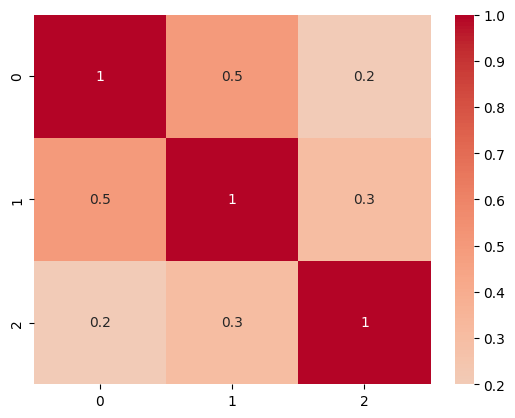

In [25]:
import seaborn as sns
import pandas as pd

# Create a sample correlation matrix
corr_matrix = pd.DataFrame(correlation_matrix)

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)


<Axes: >

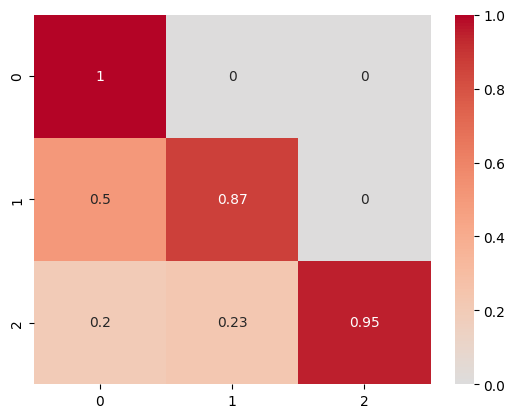

In [26]:
# Create a sample correlation matrix
chol_matrix = pd.DataFrame(cholesky_matrix)

# Plot the heatmap
sns.heatmap(chol_matrix, annot=True, cmap='coolwarm', center=0)

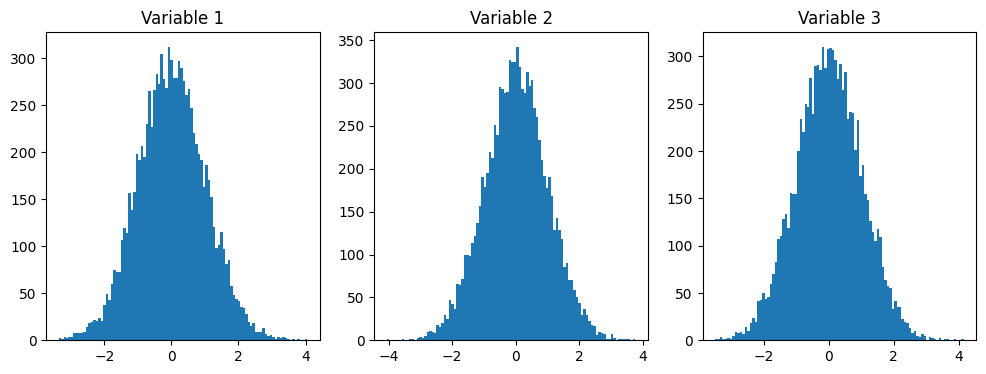

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Create three subplots in one figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Plot frequency distribution for each column
for i, column in enumerate(data1.T):
    axes[i].hist(column, bins=100)
    axes[i].set_title(f'Variable {i+1}')


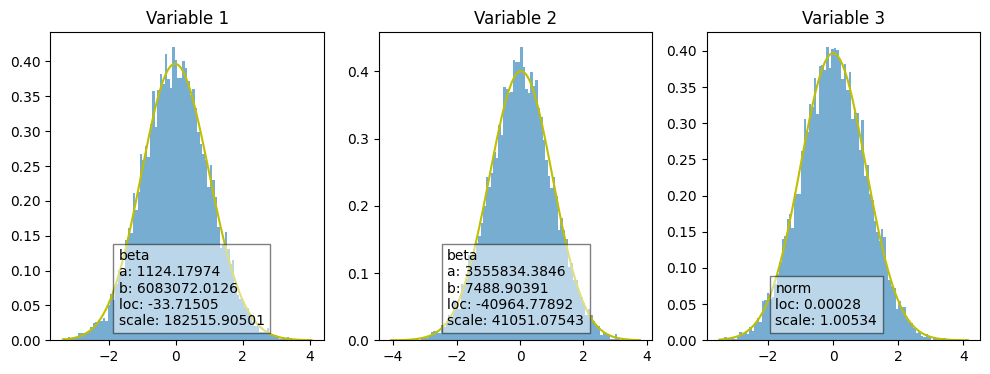

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, beta

# Create three subplots in one figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Loop over the columns of data
for i, column in enumerate(data1.T):
    # Plot histogram of the data
    n, bins, patches = axes[i].hist(column, bins=100, density=True, alpha=0.6)

    # Extract the name of the distribution and its parameters
    distribution_dict = distributions[i]
    distribution_name = list(distribution_dict.keys())[0]
    params = distribution_dict[distribution_name]

    if distribution_name == 'norm':
        # Generate a range of x values
        x = np.linspace(min(bins), max(bins), 100)
        # Calculate the corresponding pdf values
        y = norm.pdf(x, params['loc'], params['scale'])

    elif distribution_name == 'beta':
        # Generate a range of x values
        x = np.linspace(min(bins), max(bins), 100)
        # Calculate the corresponding pdf values
        y = beta.pdf(x, params['a'], params['b'], loc=params['loc'], scale=params['scale'])

    # Plot the pdf over the histogram
    axes[i].plot(x, y, 'y-', label=f'Fitted {distribution_name}')

    # Set the title
    axes[i].set_title(f'Variable {i+1}')

    # Display distribution and parameters
    param_text = "\n".join([f"{key}: {round(value, 5)}" for key, value in params.items()])
    axes[i].text(0.25, 0.05, f"{distribution_name}\n{param_text}", transform=axes[i].transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Show the plot
plt.show()



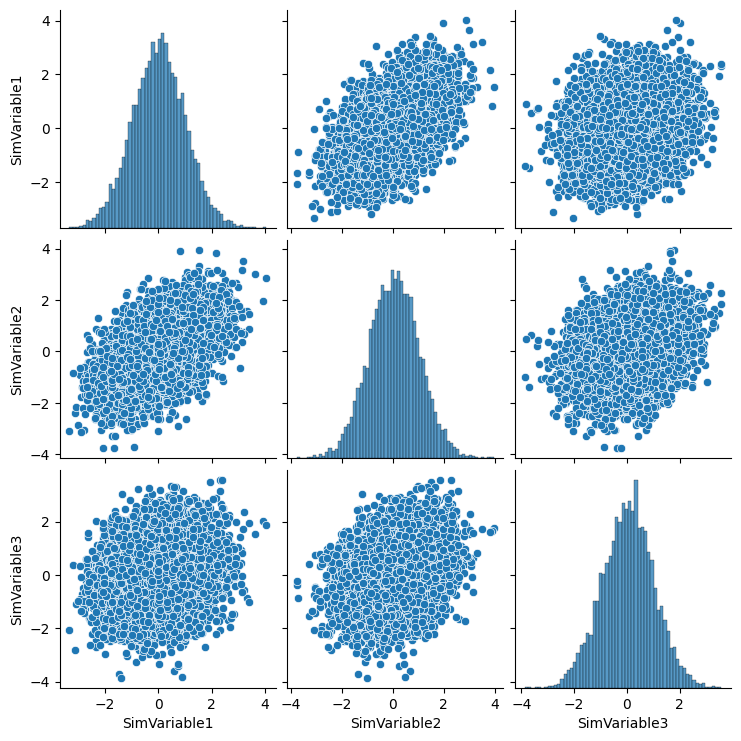

In [44]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(simulated_data, columns=['SimVariable1', 'SimVariable2', 'SimVariable3'])
sns.pairplot(df)
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

simulated_data1=pd.DataFrame(simulated_data, columns=['SimVariable1', 'SimVariable2', 'SimVariable3'])

# Create a PairGrid
g = sns.PairGrid(simulated_data1, diag_sharey=False)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)
g.map_upper(sns.kdeplot)

# Loop over the axes to add the correlation
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].annotate(
        f"Corr: {simulated_data1.iloc[:, i].corr(simulated_data1.iloc[:, j]):.2f}",
        xy=(0.1, 0.9),
        xycoords='axes fraction',
        ha='left',
        va='center',
        fontsize=10,
    )

plt.show()

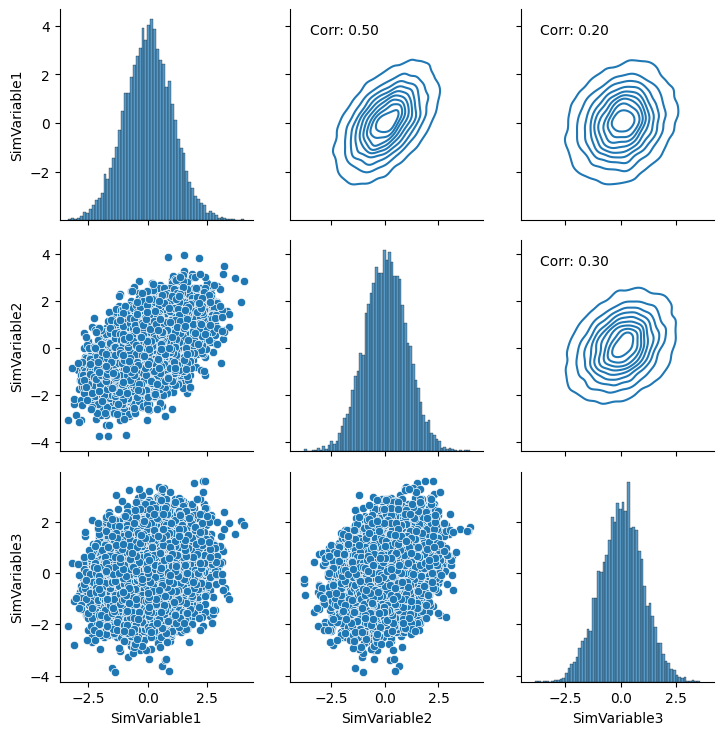

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert simulated_data1 to DataFrame if it's not already
if isinstance(simulated_data1, np.ndarray):
    simulated_data1 = pd.DataFrame(simulated_data1)

# Create a PairGrid
g = sns.PairGrid(simulated_data1, diag_sharey=False)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)
g.map_upper(sns.kdeplot)

# Loop over the axes to add the correlation
for i, j in zip(*np.tril_indices_from(g.axes, -1)):
    g.axes[j, i].annotate(
        f"Corr: {simulated_data1.iloc[:, i].corr(simulated_data1.iloc[:, j]):.2f}",
        xy=(0.1, 0.9),
        xycoords='axes fraction',
        ha='left',
        va='center',
        fontsize=10,
    )

plt.show()

In [64]:
df = pd.DataFrame([ks_values, p_values], 
                  index=['ks_values', 'p_values'], 
                  columns=['SimVariable1', 'SimVariable2', 'SimVariable3'])
df

,SimVariable1,SimVariable2,SimVariable3
ks_values,0.019996,0.016770,0.026365
p_values,0.000664,0.007133,0.000002


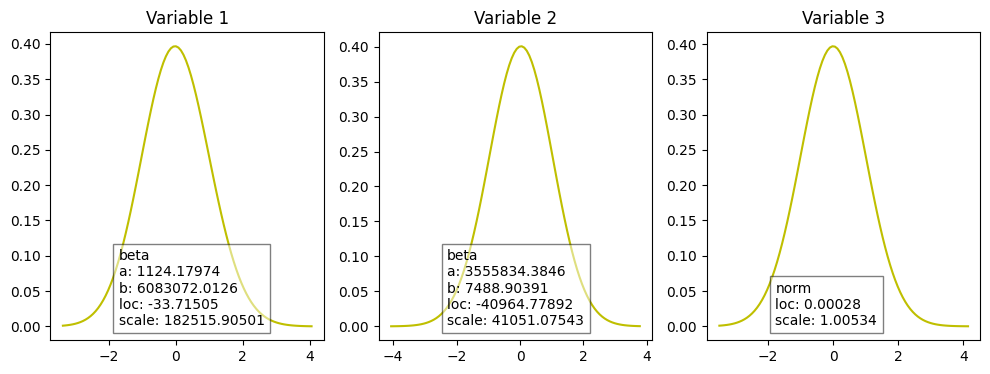

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, beta

# Create three subplots in one figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Loop over the columns of data
for i, column in enumerate(data1.T):

    # Extract the name of the distribution and its parameters
    distribution_dict = distributions[i]
    distribution_name = list(distribution_dict.keys())[0]
    params = distribution_dict[distribution_name]

    if distribution_name == 'norm':
        # Generate a range of x values
        x = np.linspace(min(column), max(column), 100)
        # Calculate the corresponding pdf values
        y = norm.pdf(x, params['loc'], params['scale'])

    elif distribution_name == 'beta':
        # Generate a range of x values
        x = np.linspace(min(column), max(column), 100)
        # Calculate the corresponding pdf values
        y = beta.pdf(x, params['a'], params['b'], loc=params['loc'], scale=params['scale'])

    # Plot the pdf
    axes[i].plot(x, y, 'y-', label=f'Fitted {distribution_name}')

    # Set the title
    axes[i].set_title(f'Variable {i+1}')

    # Display distribution and parameters
    param_text = "\n".join([f"{key}: {round(value, 5)}" for key, value in params.items()])
    axes[i].text(0.25, 0.05, f"{distribution_name}\n{param_text}", transform=axes[i].transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Show the plot
plt.show()


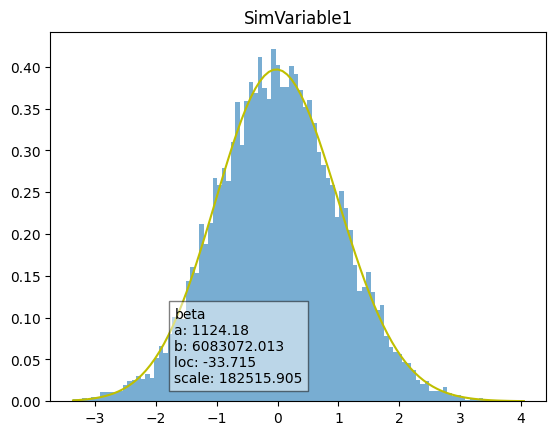

In [68]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, beta

# Extract the data for SimVariable1
sim_var_1 = data1[:, 0]  # Replace with the correct way to access SimVariable1 from your data

# Plot histogram of the data
plt.hist(sim_var_1, bins=100, density=True, alpha=0.6)

# Extract the name of the first distribution and its parameters
distribution_dict = distributions[0]
distribution_name = list(distribution_dict.keys())[0]
params = distribution_dict[distribution_name]

# Generate a range of x values
x = np.linspace(min(sim_var_1), max(sim_var_1), 100)

if distribution_name == 'norm':
    # Calculate the corresponding pdf values
    y = norm.pdf(x, params['loc'], params['scale'])

elif distribution_name == 'beta':
    # Calculate the corresponding pdf values
    y = beta.pdf(x, params['a'], params['b'], loc=params['loc'], scale=params['scale'])

# Plot the pdf over the histogram
plt.plot(x, y, 'y-', label=f'Fitted {distribution_name}')

# Set the title
plt.title(f'SimVariable1')

# Display distribution and parameters
param_text = "\n".join([f"{key}: {round(value, 3)}" for key, value in params.items()])
plt.text(0.25, 0.05, f"{distribution_name}\n{param_text}", transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Show the plot
plt.show()


In [70]:
import platform


print(f"Python Version: {platform.python_version()}")


Operating System: Linux 5.19.0-35-generic
Python Version: 3.9.13
Machine Architecture: x86_64


In [69]:
import platform

# Get machine and processor information
print(f"Machine Architecture: {platform.machine()}")
# Get operating system information
print(f"Operating System: {platform.system()} {platform.release()}")

Machine: x86_64
Processor: x86_64
OS Name: Linux
OS Release: 5.19.0-35-generic
OS Version: #36~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Feb 17 15:17:25 UTC 2
